Reading CSV...
Amount of data items:8036
Reading output values and images...
Training NN...
Train on 7713 samples, validate on 1929 samples
Epoch 1/5
7713/7713 [==============================] - 255s - loss: 0.1324 - val_loss: 0.0243
Epoch 2/5
7713/7713 [==============================] - 243s - loss: 0.0200 - val_loss: 0.0212
Epoch 3/5
7713/7713 [==============================] - 244s - loss: 0.0182 - val_loss: 0.0207
Epoch 4/5
7713/7713 [==============================] - 256s - loss: 0.0164 - val_loss: 0.0206
Epoch 5/5
7713/7713 [==============================] - 259s - loss: 0.0152 - val_loss: 0.0210


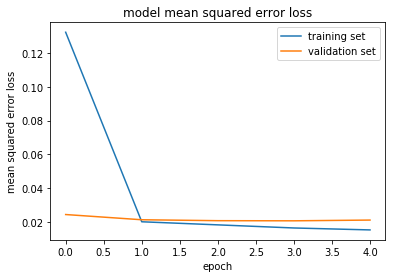

Trained model saved...


In [2]:
# modules import section
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

# import data
# data buffers
input_images = []
lines = []
output_values = []
base_path = './data/'
data_file_csv = open(base_path + 'driving_log.csv')
data_reader = csv.reader(data_file_csv)
first_line = True
# read csv file
print('Reading CSV...')
for line in data_reader:
    if first_line:
        first_line = False
    else:
        lines.append(line)
                     
print('Amount of data items:' + str(len(lines)))

# read images and output values
print('Reading output values and images...')

# Correction for perspective of different camaras frmo different angles
steering_correction = 0.2

# Skip samples to keep memory under control, else system runs out of memory
# also keep training times without a GPU at a reasonable range

skip_images = 0
for line in lines:
    skip_images+= 1
    if skip_images == 5:
        skip_images = 0
        for i in range(3):
            image_file_name = line[i]
            image_full_filename = image_file_name.split('/')[-1]
            image_path = base_path + 'IMG/' + image_full_filename
            image = cv2.imread(image_path)
            input_images.append(image)
        output_value_steering = float(line[3])
        output_value_steering_left = output_value_steering + steering_correction
        output_value_steering_right = output_value_steering - steering_correction
        output_values.append(output_value_steering)
        output_values.append(output_value_steering_left)
        output_values.append(output_value_steering_right)

aug_input_images = []
aug_output_values = []
for input_image, output_value in zip(input_images, output_values):
    aug_input_images.append(input_image)
    aug_output_values.append(output_value)
    aug_input_images.append(cv2.flip(input_image, 1))
    aug_output_values.append(-1.0 * output_value)

# Free a bit of memory
input_images = []
output_values = []

# convert to np arrays
X_train_data = np.array(aug_input_images)
y_train_data = np.array(aug_output_values)
    
#create a LeNet covnet with keras
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Conv2D(6,(5,5),activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6,(5,5),activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

# Train covnet
print('Training NN...')
model.compile(loss='mse', optimizer='adam')
fit_history =  model.fit(X_train_data, y_train_data, validation_split=0.2, 
                         shuffle=True, epochs=5, verbose=1)
# Plot cost history
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Save model to be used later by drive.py
model.save('model.h5')
print('Trained model saved...')
